<a href="https://colab.research.google.com/github/infernora/CSE425_project/blob/main/CSE425_Project_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torchvision.datasets as datasets

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


Exploratory Data Analysis (EDA)

In [ ]:
# Load MNIST dataset without transformations for EDA
train_data = datasets.MNIST(root='./data', train=True, download=True)
test_data = datasets.MNIST(root='./data', train=False, download=True)

# Basic information
print("=== Dataset Overview ===")
print(f"Training samples: {len(train_data)}")
print(f"Test samples: {len(test_data)}")
print(f"Image shape: {train_data[0][0].size}")
print(f"Number of classes: {len(train_data.classes)}")

100%|██████████| 9.91M/9.91M [00:11<00:00, 898kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]
100%|██████████| 1.65M/1.65M [00:06<00:00, 240kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 1.24MB/s]

=== Dataset Overview ===
Training samples: 60000
Test samples: 10000
Image shape: (28, 28)
Number of classes: 10


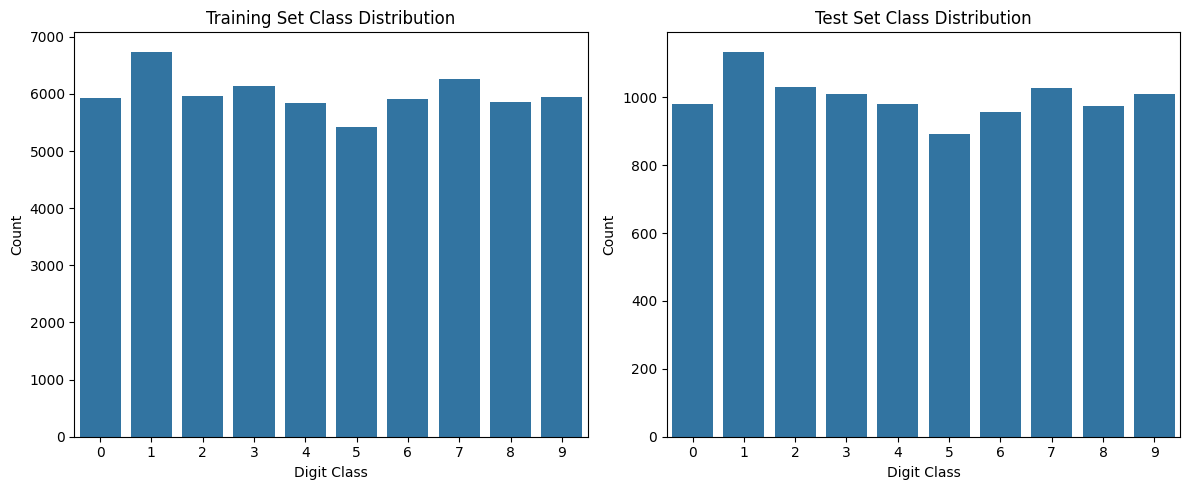


=== Class Distribution ===
Training set:
Class 0: 5923 samples (9.9%)
Class 1: 6742 samples (11.2%)
Class 2: 5958 samples (9.9%)
Class 3: 6131 samples (10.2%)
Class 4: 5842 samples (9.7%)
Class 5: 5421 samples (9.0%)
Class 6: 5918 samples (9.9%)
Class 7: 6265 samples (10.4%)
Class 8: 5851 samples (9.8%)
Class 9: 5949 samples (9.9%)

Test set:
Class 0: 980 samples (9.8%)
Class 1: 1135 samples (11.3%)
Class 2: 1032 samples (10.3%)
Class 3: 1010 samples (10.1%)
Class 4: 982 samples (9.8%)
Class 5: 892 samples (8.9%)
Class 6: 958 samples (9.6%)
Class 7: 1028 samples (10.3%)
Class 8: 974 samples (9.7%)
Class 9: 1009 samples (10.1%)


In [ ]:
# Get all labels
train_labels = [label for _, label in train_data]
test_labels = [label for _, label in test_data]

# Plot class distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.countplot(x=train_labels)
plt.title('Training Set Class Distribution')
plt.xlabel('Digit Class')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.countplot(x=test_labels)
plt.title('Test Set Class Distribution')
plt.xlabel('Digit Class')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Print exact counts
print("\n=== Class Distribution ===")
print("Training set:")
for i in range(10):
    print(f"Class {i}: {train_labels.count(i)} samples ({train_labels.count(i)/len(train_labels):.1%})")

print("\nTest set:")
for i in range(10):
    print(f"Class {i}: {test_labels.count(i)} samples ({test_labels.count(i)/len(test_labels):.1%})")

Main code:

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])
train_data = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=256, shuffle=True)

# For true labels
all_labels = [label for _, label in train_data]

Auto-encoder

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),
            nn.Unflatten(1, (1, 28, 28))
        )
    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat


In [ ]:
autoencoder = Autoencoder().to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)
criterion = nn.MSELoss()

for epoch in range(20):
    autoencoder.train()
    total_loss = 0
    for img, _ in train_loader:
        img = img.to(device)
        output = autoencoder(img)
        loss = criterion(output, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")


Epoch 1, Loss: 0.0620
Epoch 2, Loss: 0.0275
Epoch 3, Loss: 0.0186
Epoch 4, Loss: 0.0149
Epoch 5, Loss: 0.0127
Epoch 6, Loss: 0.0113
Epoch 7, Loss: 0.0102
Epoch 8, Loss: 0.0094
Epoch 9, Loss: 0.0087
Epoch 10, Loss: 0.0082
Epoch 11, Loss: 0.0077
Epoch 12, Loss: 0.0073
Epoch 13, Loss: 0.0070
Epoch 14, Loss: 0.0067
Epoch 15, Loss: 0.0065
Epoch 16, Loss: 0.0063
Epoch 17, Loss: 0.0061
Epoch 18, Loss: 0.0059
Epoch 19, Loss: 0.0057
Epoch 20, Loss: 0.0056


In [ ]:
autoencoder.eval()
latents = []
with torch.no_grad():
    for img, _ in train_loader:
        img = img.to(device)
        z = autoencoder.encoder(img)
        latents.append(z.cpu())
latents = torch.cat(latents).numpy()

kmeans = KMeans(n_clusters=10, n_init=20)
preds = kmeans.fit_predict(latents)

In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

silhouette = silhouette_score(latents, preds)
davies = davies_bouldin_score(latents, preds)
ch_score = calinski_harabasz_score(latents, preds)

print(f"\nEvaluation of KMeans on Autoencoder Latents:")
print(f"Silhouette Score: {silhouette:.4f}")
print(f"Davies-Bouldin Index: {davies:.4f}")
print(f"Calinski-Harabasz Index: {ch_score:.2f}")


Evaluation of KMeans on Autoencoder Latents:
Silhouette Score: 0.0833
Davies-Bouldin Index: 2.4259
Calinski-Harabasz Index: 3286.42


In [ ]:
import numpy as np

# Sample 5,000 points
subset_size = 5000
indices = np.random.choice(len(latents), size=subset_size, replace=False)

subset_latents = latents[indices]
subset_preds = preds[indices]
subset_labels = np.array([label for _, label in train_data])[indices]


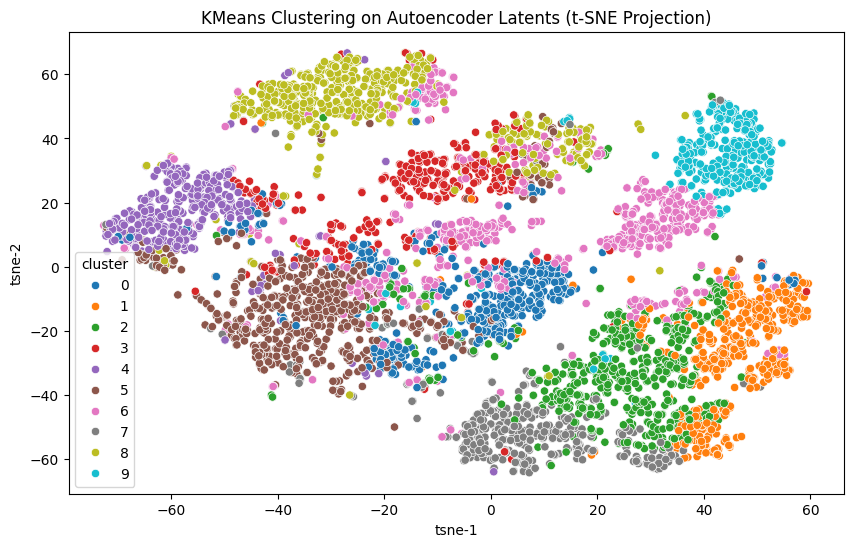

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

tsne = TSNE(n_components=2, random_state=42, init='pca')
tsne_result = tsne.fit_transform(subset_latents)

df = pd.DataFrame({
    "tsne-1": tsne_result[:, 0],
    "tsne-2": tsne_result[:, 1],
    "cluster": subset_preds,
    "label": subset_labels
})

# Plot using predicted cluster labels
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="tsne-1", y="tsne-2", hue="cluster", palette="tab10", legend="full")
plt.title("KMeans Clustering on Autoencoder Latents (t-SNE Projection)")
plt.show()


Deep Embedding Clustering (DEC)

In [ ]:
class ClusteringLayer(nn.Module):
    def __init__(self, n_clusters, embedding_dim):
        super().__init__()
        self.clusters = nn.Parameter(torch.Tensor(n_clusters, embedding_dim))
        nn.init.xavier_uniform_(self.clusters.data)

    def forward(self, z):
        q = 1.0 / (1.0 + torch.sum((z.unsqueeze(1) - self.clusters) ** 2, dim=2))
        q = q.pow((1 + 1.0) / 2.0)
        q = (q.t() / torch.sum(q, dim=1)).t()
        return q

class DEC(nn.Module):
    def __init__(self, autoencoder, n_clusters=10):
        super().__init__()
        self.encoder = autoencoder.encoder
        self.clustering_layer = ClusteringLayer(n_clusters, 64)

    def forward(self, x):
        z = self.encoder(x)
        q = self.clustering_layer(z)
        return q, z


In [ ]:
def target_distribution(q):
    weight = q**2 / torch.sum(q, dim=0)
    return (weight.t() / torch.sum(weight, dim=1)).t()


In [ ]:
dec = DEC(autoencoder, n_clusters=10).to(device)
dec.clustering_layer.clusters.data = torch.tensor(kmeans.cluster_centers_, dtype=torch.float, device=device)

# Add weight decay (L2 regularization)
optimizer = torch.optim.Adam(dec.parameters(), lr=1e-3, weight_decay=1e-4)
loss_fn = nn.KLDivLoss(reduction='batchmean')

# Early stopping parameters
best_loss = float('inf')
patience = 5
wait = 0
num_epochs = 20

for epoch in range(num_epochs):
    dec.train()
    total_loss = 0

    for x, _ in train_loader:
        x = x.to(device)
        q, _ = dec(x)
        p = target_distribution(q).detach()
        loss = loss_fn(torch.log(q), p)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"DEC Epoch {epoch+1}, KL Loss: {avg_loss:.4f}")

    # Early stopping check
    if avg_loss < best_loss - 1e-4:  # improvement threshold
        best_loss = avg_loss
        wait = 0
    else:
        wait += 1
        print(f"  No improvement. Patience counter: {wait}/{patience}")
        if wait >= patience:
            print("Early stopping triggered.")
            break


DEC Epoch 1, KL Loss: 0.2022
DEC Epoch 2, KL Loss: 0.2208
  No improvement. Patience counter: 1/5
DEC Epoch 3, KL Loss: 0.2006
DEC Epoch 4, KL Loss: 0.1859
DEC Epoch 5, KL Loss: 0.1763
DEC Epoch 6, KL Loss: 0.1687
DEC Epoch 7, KL Loss: 0.1636
DEC Epoch 8, KL Loss: 0.1593
DEC Epoch 9, KL Loss: 0.1555
DEC Epoch 10, KL Loss: 0.1528
DEC Epoch 11, KL Loss: 0.1485
DEC Epoch 12, KL Loss: 0.1457
DEC Epoch 13, KL Loss: 0.1429
DEC Epoch 14, KL Loss: 0.1400
DEC Epoch 15, KL Loss: 0.1372
DEC Epoch 16, KL Loss: 0.1344
DEC Epoch 17, KL Loss: 0.1325
DEC Epoch 18, KL Loss: 0.1305
DEC Epoch 19, KL Loss: 0.1286
DEC Epoch 20, KL Loss: 0.1264


In [ ]:
dec.eval()
final_latents = []
final_preds = []

with torch.no_grad():
    for img, _ in train_loader:
        img = img.to(device)
        _, z = dec(img)
        q = dec.clustering_layer(z)
        preds = torch.argmax(q, dim=1)
        final_latents.append(z.cpu())
        final_preds.append(preds.cpu())

final_latents = torch.cat(final_latents).numpy()
final_preds = torch.cat(final_preds).numpy()


In [ ]:
silhouette = silhouette_score(final_latents, final_preds)
davies = davies_bouldin_score(final_latents, final_preds)
ch = calinski_harabasz_score(final_latents, final_preds)

print(f"Silhouette Score: {silhouette:.4f}")
print(f"Davies-Bouldin Index: {davies:.4f}")
print(f"Calinski-Harabasz Index: {ch:.2f}")


Silhouette Score: 0.7182
Davies-Bouldin Index: 0.3558
Calinski-Harabasz Index: 202543.61


In [ ]:
import numpy as np

# Limit to 5000 random samples
subset_size = 5000
indices = np.random.choice(len(final_latents), size=subset_size, replace=False)

subset_latents = final_latents[indices]
subset_clusters = final_preds[indices]
subset_labels = np.array(all_labels)[indices]  # Ground truth labels if needed


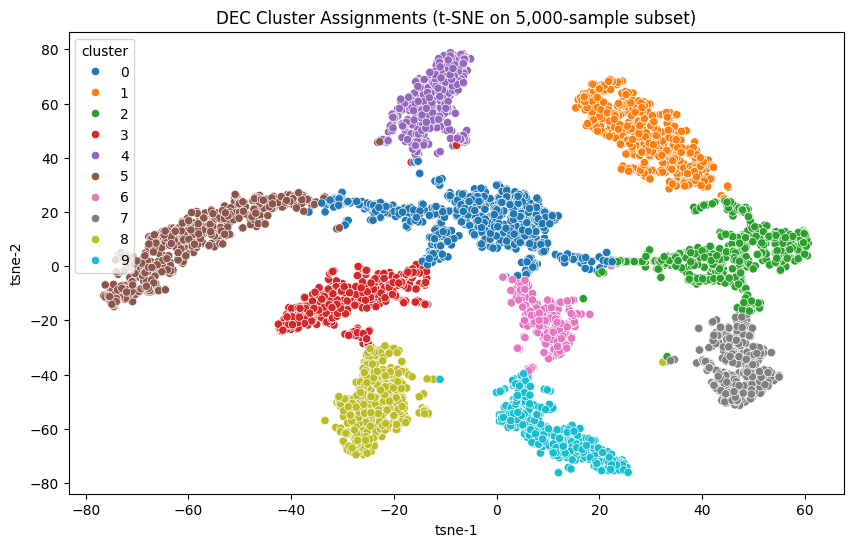

In [ ]:
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42, init='pca')
tsne_result = tsne.fit_transform(subset_latents)

df = pd.DataFrame({
    "tsne-1": tsne_result[:, 0],
    "tsne-2": tsne_result[:, 1],
    "cluster": subset_clusters,
    "label": subset_labels
})

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="tsne-1", y="tsne-2", hue="cluster", palette="tab10", legend='full')
plt.title("DEC Cluster Assignments (t-SNE on 5,000-sample subset)")
plt.show()
